# (3-class case) Distinct Representations for Keys and Values

In [1]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.style.use('ggplot')

sigm_fn = torch.nn.functional.sigmoid

In [2]:
!python --version

Python 3.10.12


In [3]:
torch.__version__

'2.5.1+cu121'

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
num_datapoints = 300

num_iterations = 10000

num_classes = 3
key_dimension = 2

# Generate random key/value pairs
data_keys = torch.randn([num_datapoints, key_dimension]).uniform_(0, 1)  # this could just be torch.rand; keeping the code used to produce the paper figure
data_values = torch.rand([num_datapoints, key_dimension])

class_features = torch.tensor([[1, 0], [0, 1], [1, 1]])

target_classes = torch.randint(low=0, high=num_classes, size=[num_datapoints])

target_class_features = class_features[target_classes].float()

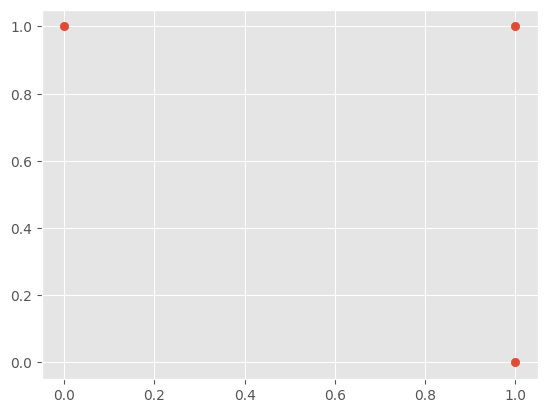

In [6]:
# visualize class features
plt.scatter(x=class_features[:, 0], y=class_features[:, 1])

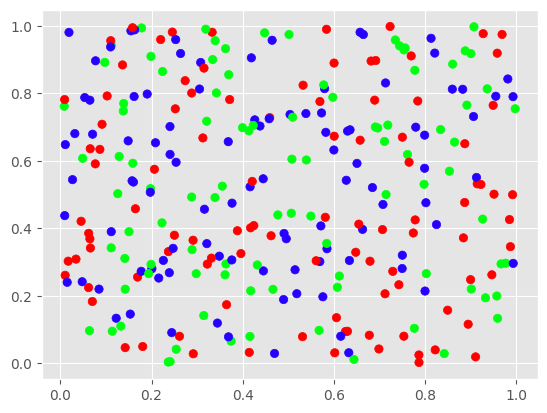

In [7]:
# Visualize keys at initialization
# color encodes the class

assert key_dimension == 2  # This is visualization is for 2D keys

colors = cm.hsv(np.linspace(0, 0.7, num_classes))
class_colors = colors[target_classes]

plt.scatter(x=data_keys[:, 0], y=data_keys[:, 1], color=class_colors)

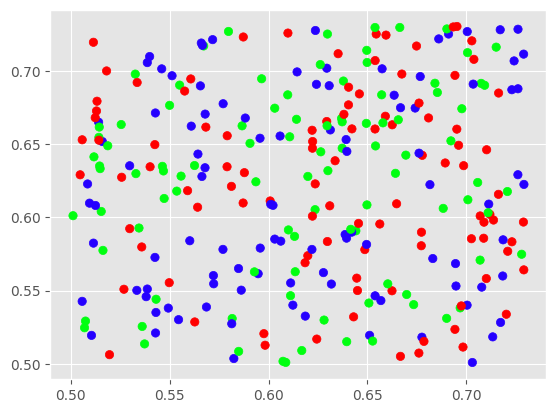

In [8]:
# same for values

colors = cm.hsv(np.linspace(0, 0.7, num_classes))
class_colors = colors[target_classes]

plt.scatter(x=sigm_fn(data_values)[:, 0], y=sigm_fn(data_values)[:, 1], color=class_colors)

In [9]:
# model
class SoftmaxKeyValueMemory(nn.Module):
    def __init__(self, initial_keys, initial_values, device='cpu'):
        super().__init__()

        self.key_representations = nn.Parameter(initial_keys)
        self.value_representations = nn.Parameter(initial_values)

        self.softmax = torch.nn.Softmax(dim=0)

    def compute_pairwise_dot_product(self, X):
        return X.detach().mm(X.T)

    def forward(self):
        attn_weight_mat = self.compute_pairwise_dot_product(self.key_representations) * (key_dimension ** - 0.5)
        attn_weight_mat = self.softmax(attn_weight_mat)
        return torch.matmul(attn_weight_mat.T, sigm_fn(self.value_representations))

In [10]:
loss_fn = torch.nn.MSELoss()

model = SoftmaxKeyValueMemory(data_keys.clone(), data_values.clone())

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [11]:
# transparency for the trajectory plot
alpha = 0.01
alpha_step = (0.1 - 0.01) / num_iterations

plt_colors = []
plt_alphas = []

loss_val = []

plt_x = []
plt_y = []

val_plt_x = []
val_plt_y = []

# main training loop
for iter in range(num_iterations):
    val = model()

    loss = loss_fn(val, target_class_features)
    loss.backward()
    optimizer.step()

    cur_key_representations = model.key_representations.clone().detach().to('cpu').numpy()
    cur_value_representations = sigm_fn(model.value_representations.clone()).detach().to('cpu').numpy()

    alpha += alpha_step

    loss_val.append(loss.item())

    plt_colors.append(class_colors)
    plt_alphas.append(np.ones(cur_key_representations[:, 1].shape) * alpha)

    plt_x.append(cur_key_representations[:, 0])
    plt_y.append(cur_key_representations[:, 1])

    val_plt_x.append(cur_value_representations[:, 0])
    val_plt_y.append(cur_value_representations[:, 1])


# Results


In [12]:
# common to key/value
col = np.concatenate(plt_colors)
alphas = np.concatenate(plt_alphas)

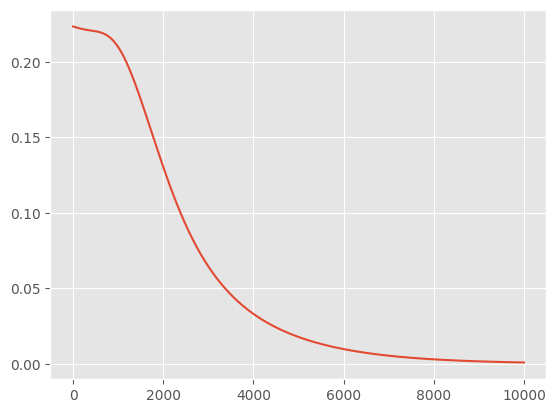

In [13]:
# loss
plt.plot(loss_val)

# Key Representations

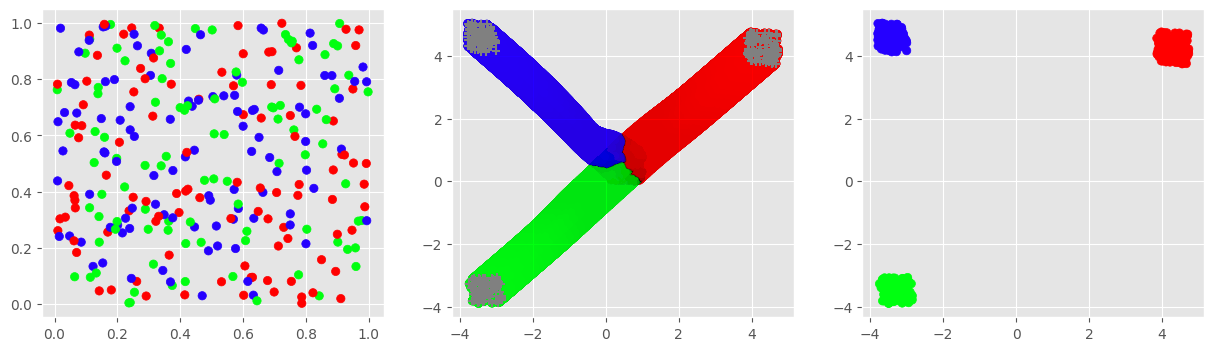

In [14]:
cur_key_representations = model.key_representations.clone().detach().to('cpu').numpy()

key_xs = np.concatenate(plt_x)
key_ys = np.concatenate(plt_y)

f, (a0, a1, a2) = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(15)

a0.scatter(x=data_keys[:, 0], y=data_keys[:, 1], color=class_colors)
a1.scatter(x=key_xs, y=key_ys, color=col, alpha=alphas)
a1.scatter(x=cur_key_representations[:, 0], y=cur_key_representations[:, 1], c='grey', marker='+')

a2.scatter(x=cur_key_representations[:, 0], y=cur_key_representations[:, 1], color=class_colors)


# Value Representations

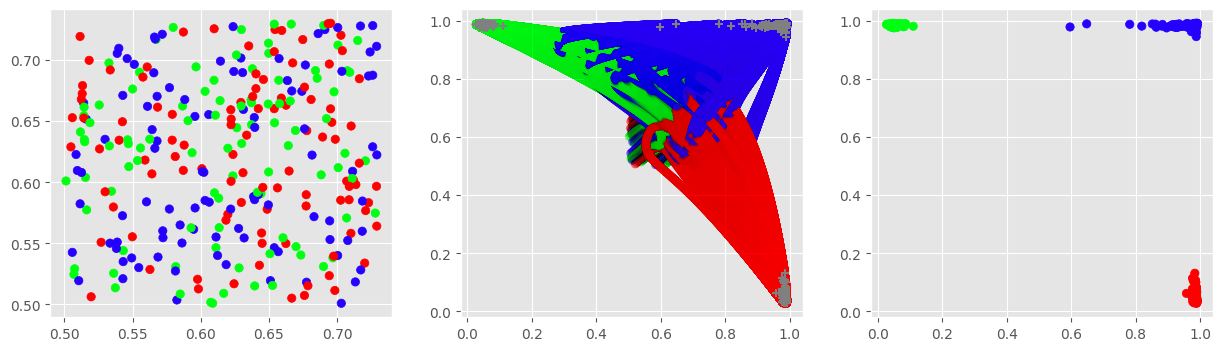

In [15]:
cur_value_representations = sigm_fn(model.value_representations).clone().detach().to('cpu').numpy()

val_xs = np.concatenate(val_plt_x)
val_ys = np.concatenate(val_plt_y)

f, (a0, a1, a2) = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(15)

a0.scatter(x=sigm_fn(data_values)[:, 0], y=sigm_fn(data_values)[:, 1], color=class_colors)
a1.scatter(x=val_xs, y=val_ys, color=col, alpha=alphas)
a1.scatter(x=cur_value_representations[:, 0], y=cur_value_representations[:, 1], c='grey', marker='+')

a2.scatter(x=cur_value_representations[:, 0], y=cur_value_representations[:, 1], color=class_colors)
